In [39]:
from discretize import TensorMesh, TreeMesh
from SimPEG import utils
import numpy as np
import discretize
from pymatsolver import PardisoSolver
from simpegaem import create_local_mesh, SimulationAEM, run_simulation_time_domain
from matplotlib import pyplot as plt
from SimPEG import maps, utils
import SimPEG.electromagnetics.time_domain as tdem

def custom_waveform(t, tmax):
    out = np.cos(0.5*np.pi*(t-tmax)/(tmax+0.02))
    out[t>=tmax] = 1 + (t[t>=tmax] - tmax)/tmax
    return out

waveform_times = np.r_[np.linspace(-0.02, -0.011, 10), -np.logspace(-2, -6, 61), 0.]
waveform_current = custom_waveform(waveform_times, -0.0055)
general_waveform = tdem.sources.PiecewiseLinearWaveform(
        times=waveform_times, currents=waveform_current, 
        has_initial_fields=True
)

receiver_location = np.array([0., 0., 30.])
receiver_orientation = "z"                    # "x", "y" or "z"
times_ch1 = np.logspace(-5.5, -2, 41)               # time channels
times_ch2 = np.logspace(-5.5, -2, 31) 

receiver_list_ch1 = [
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times_ch1, orientation=receiver_orientation
    )
]

receiver_list_ch2 = [
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times_ch2, orientation=receiver_orientation
    )
]

source_location = np.array([0., 0., 30.])  
source_radius = 10.
current_amplitude = 1.

source_list = []

    
# General Waveform
source_list.append(
    tdem.sources.CircularLoop(
        receiver_list=receiver_list_ch1, location=source_location,
        waveform=general_waveform, radius=source_radius, current=current_amplitude
    ),
)
source_list.append(    
    tdem.sources.CircularLoop(
        receiver_list=receiver_list_ch2, location=source_location,
        waveform=general_waveform, radius=source_radius, current=current_amplitude
    )

)

# Survey
survey = tdem.Survey(source_list)

In [40]:
rx = receiver_list_ch1[0]

In [41]:
dx = 100
dy = 100
dz = 5
hx = np.ones(100) * dx
hy = np.ones(100) * dx
hz = np.ones(60) * dz
mesh =TensorMesh([hx, hy, hz], x0=[-hx.sum()/2, -hy.sum()/2, -hz.sum() + 30.])
ind_active = mesh.gridCC[:,2]<0.
sigma_aquifer = 1./50.
sigma_aquitard = 1./15.

sigma_global = np.ones(mesh.n_cells) * 1./1e8
sigma_global[ind_active] = sigma_aquitard
layer_salinas_aquitard_ind = np.logical_and(mesh.gridCC[:,2]<0., mesh.gridCC[:,2]>-30)
layer_180_ft_aquifer = np.logical_and(mesh.gridCC[:,2]<-30., mesh.gridCC[:,2]>-80)
layer_180_400_ft_aquitard = np.logical_and(mesh.gridCC[:,2]<-80., mesh.gridCC[:,2]>-100)
layer_400_ft_aquifer = np.logical_and(mesh.gridCC[:,2]<-100., mesh.gridCC[:,2]>-160)
sigma_global[layer_180_ft_aquifer] = sigma_aquifer
sigma_global[layer_400_ft_aquifer] = sigma_aquifer

In [42]:
from matplotlib.colors import LogNorm
rho_global = 1./sigma_global
rho_global[~ind_active] = np.nan

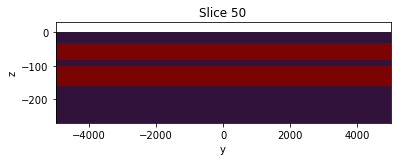

In [43]:
mesh.plotSlice(rho_global, normal='X', pcolor_opts={'norm':LogNorm(), 'cmap':'turbo'})
plt.gca().set_aspect(10)

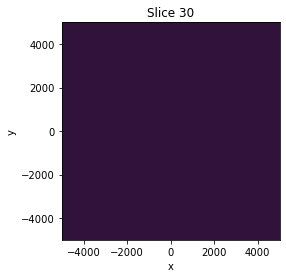

In [44]:
mesh.plotSlice(rho_global, normal='Z', pcolor_opts={'norm':LogNorm(), 'cmap':'turbo'})
plt.gca().set_aspect(1)

In [45]:
topo_location = np.array([0, 0, 0])
x = np.linspace(-4000, 4000)
y = np.linspace(-4000, 4000)
z = np.array([0.])
topo = utils.ndgrid(x,y,z)
mesh_tree = create_local_mesh(
    source_location, receiver_location, topo_location,
    padding_distance=[[4000., 4000.], [4000., 4000.], [4000., 4000.]]
)

In [46]:
receiver_location

array([ 0.,  0., 30.])

In [47]:
def generate_time_steps(
    n_constant_steps=15, increase_rate=3, start_time_step=5e-7, n_per_step=5
):
    time_steps = []
    for i_step in range(n_constant_steps):
        ht = np.ones(n_per_step) * start_time_step*increase_rate**i_step
        time_steps.append(ht)
    print("t_min:{:.1e}, t_max:{:.1e}".format(start_time_step, np.sum(time_steps)))
    return np.hstack(time_steps)

In [48]:
P_global_to_local = discretize.utils.volume_average(mesh, mesh_tree)

In [49]:
sigma_local = P_global_to_local * sigma_global

(-300.0, 300.0)

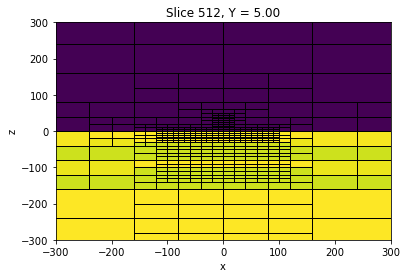

In [50]:
mesh_tree.plot_slice(sigma_local, grid=True, normal='Y', pcolor_opts={'norm':LogNorm()})
plt.xlim(-300, 300)
plt.ylim(-300, 300)

In [51]:
survey.source_list

In [52]:
simulation_3d = SimulationAEM(
    mesh=mesh_tree, survey=survey, sigmaMap=maps.IdentityMap(mesh_tree),
    solver=PardisoSolver
)
time_steps = generate_time_steps(n_constant_steps=14, increase_rate=2, start_time_step=5e-7, n_per_step=5)
simulation_3d.time_steps = time_steps

t_min:5.0e-07, t_max:4.1e-02


In [53]:
sigma_local.shape

(3796,)

In [54]:
mesh_tree.n_cells

3796

In [55]:
# %%time
# d_off = simulation_3d.dpred(sigma_local)

In [56]:
# def run_simulation_time_domain(args):
#     source_list, mesh_local, sigma_local, time_steps = args  
#     survey = tdem.Survey(source_list)
#     simulation_3d = SimulationAEM(
#         mesh=mesh_local, 
#         survey=survey, 
#         sigmaMap=maps.IdentityMap(mesh_local),
#         solver=PardisoSolver,
#         time_steps=time_steps
#     )
#     dpred = simulation_3d.dpred(sigma_local)
#     return dpred

In [57]:
args = (source_list[0], sigma_local, mesh_tree, time_steps)
dpred = run_simulation_time_domain(args)

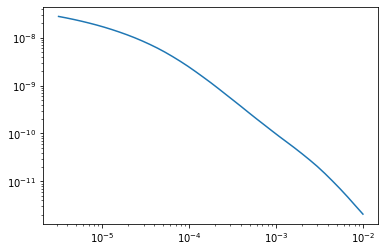

In [58]:
plt.loglog(times_ch1, -dpred[:times_ch1.size])

In [59]:
x = np.linspace(-4000, 4000, 11)
y = np.linspace(-4000, 4000, 3)
z = np.array([0.])
topo = utils.ndgrid(x, y, z)

In [60]:
receiver_orientation = "z"                    # "x", "y" or "z"
times = np.logspace(-5.5, -2, 41)               # time channels
source_radius = 10.
current_amplitude = 1.
source_list = []
n_src = topo.shape[0]

for i_src in range(n_src):
    source_location = np.array([topo[i_src,0], topo[i_src,1], topo[i_src,2]+30.])
    receiver_location = np.array([topo[i_src,0], topo[i_src,1], topo[i_src,2]+30.])

    receiver_list = [
        tdem.receivers.PointMagneticFluxTimeDerivative(
            receiver_location, times, orientation=receiver_orientation
        )
    ]

    # General Waveform
    source_list.append(
        tdem.sources.CircularLoop(
            receiver_list=receiver_list, location=source_location,
            waveform=general_waveform, radius=source_radius, current=current_amplitude
        ),
    )

# Survey
survey = tdem.Survey(source_list)

In [61]:
from simpegaem import GlobalSimulationAEM
sim = GlobalSimulationAEM(
    mesh=mesh, 
    topo=topo, 
    sigmaMap=maps.IdentityMap(mesh), 
    survey=survey, 
    time_steps=time_steps, 
    parallel=False,
    n_cpu=4
)

>> Serial version is used


In [70]:
# %%time
# sim._get_P_global_to_locals()

In [71]:
%%time
dpred = sim.dpred(sigma_global)

Wall time: 1min 10s


In [68]:
dpred.reshape((times.size, n_src))

array([[-2.77784955e-08, -2.59122801e-08, -2.40124403e-08, ...,
        -6.60487461e-11, -5.01958450e-11, -3.76927546e-11],
       [-2.80148557e-11, -2.05118863e-11, -1.45949142e-11, ...,
        -6.50219437e-10, -4.87839145e-10, -3.65157181e-10],
       [-2.71613027e-10, -2.03026562e-10, -1.52882590e-10, ...,
        -4.97448022e-09, -4.02329749e-09, -3.21184283e-09],
       ...,
       [-3.65157181e-10, -2.71613027e-10, -2.03026562e-10, ...,
        -6.05166218e-09, -4.97448022e-09, -4.02329749e-09],
       [-3.21184283e-09, -2.53080189e-09, -1.96160290e-09, ...,
        -1.83887841e-08, -1.65721583e-08, -1.47976665e-08],
       [-1.30997065e-08, -1.14949023e-08, -9.97717866e-09, ...,
        -4.70787336e-12, -3.11449364e-12, -2.06861500e-12]])